In [ ]:
!pip install tensorflow-addons
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 7.2 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [ ]:
img_size = (224, 224)
input_shape = img_size + (3,)
num_classes = 3
batch_size = 32

In [ ]:
pip install tensorflow-probability

In [ ]:
img_size = (224, 224)
batch_size = 32

# Load datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory='/content/drive/MyDrive/dt/train',
    label_mode='categorical',
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    directory='/content/drive/MyDrive/dt/validation',
    shuffle=False,
    label_mode='categorical',
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    directory='/content/drive/MyDrive/dt/test',
    shuffle=False,
    label_mode='categorical',
    seed=123,
    image_size=img_size,  # Load images with their original sizes
    batch_size=batch_size
)

train_ds = train_ds.concatenate(val_ds)



data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomBrightness(0.2),
])


Found 1052 files belonging to 3 classes.
Found 133 files belonging to 3 classes.
Found 128 files belonging to 3 classes.


In [ ]:
augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
augmented_train_ds = augmented_train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)


Lớp Đốm góc cạnh: 396 ảnh
Lớp Khỏe mạnh: 392 ảnh
Lớp Gỉ sét: 397 ảnh


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

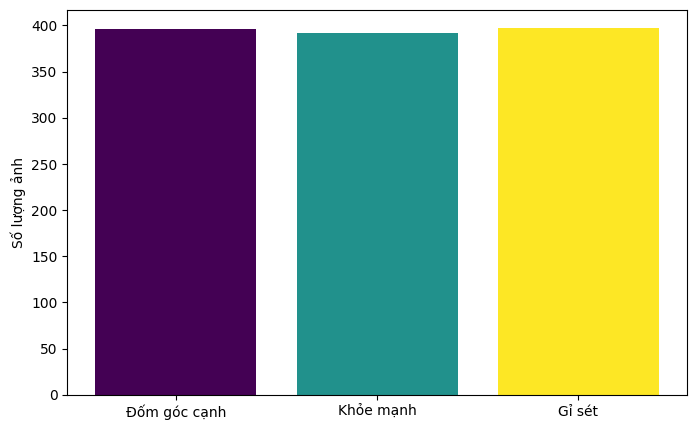

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Giả sử tên lớp cho các chỉ số tương ứng
class_names = {0: 'Đốm góc cạnh', 1: 'Gỉ sét', 2: 'Khỏe mạnh'}

# Tạo một từ điển để đếm số lượng ảnh cho mỗi lớp
class_counts = {}

# Duyệt qua từng batch trong dataset và đếm số lượng ảnh cho mỗi lớp
for images, labels in augmented_train_ds:
    for label in labels.numpy():
        class_idx = tf.argmax(label).numpy()  # Lấy chỉ số của lớp
        class_counts[class_idx] = class_counts.get(class_idx, 0) + 1

# In số lượng ảnh của từng lớp
for class_idx, count in class_counts.items():
    print(f"Lớp {class_names[class_idx]}: {count} ảnh")

# Tạo màu cho mỗi lớp
colors = plt.cm.viridis(np.linspace(0, 1, len(class_counts)))

# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
plt.bar([class_names[idx] for idx in class_counts.keys()], class_counts.values(), color=colors)
plt.ylabel('Số lượng ảnh')
plt


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input, Lambda
from tensorflow.keras.models import Model

# img_size1 = (100, 100)
# input_shape = img_size1 + (3,)
inputs = Input(shape=input_shape)
x = Lambda(preprocess_input)(inputs)


vgg_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape, input_tensor=x)


for layer in vgg_model.layers:
    layer.trainable = False


x = GlobalAveragePooling2D()(vgg_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=inputs, outputs=predictions)

model.summary()


80134624/80134624 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                              

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss = 'categorical_crossentropy',
              optimizer = optimizer,
              metrics = ['accuracy'])

In [ ]:
checkpoint_path = "models/best_vgg19.h5"
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
history = model.fit(augmented_train_ds, validation_data=test_ds, epochs=40, callbacks=[model_checkpoint, early_stopping])

Epoch 1/40
38/38 [==============================] - ETA: 0s - loss: 1.7844 - accuracy: 0.5907
Epoch 1: val_accuracy improved from -inf to 0.78125, saving model to models/best_vgg19.h5
38/38 [==============================] - 195s 4s/step - loss: 1.7844 - accuracy: 0.5907 - val_loss: 0.5826 - val_accuracy: 0.7812


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/40
38/38 [==============================] - ETA: 0s - loss: 0.8825 - accuracy: 0.7021
Epoch 2: val_accuracy improved from 0.78125 to 0.79688, saving model to models/best_vgg19.h5
38/38 [==============================] - 20s 476ms/step - loss: 0.8825 - accuracy: 0.7021 - val_loss: 0.5741 - val_accuracy: 0.7969
Epoch 3/40
38/38 [==============================] - ETA: 0s - loss: 0.5982 - accuracy: 0.7671
Epoch 3: val_accuracy did not improve from 0.79688
38/38 [==============================] - 21s 507ms/step - loss: 0.5982 - accuracy: 0.7671 - val_loss: 0.5572 - val_accuracy: 0.7891
Epoch 4/40
38/38 [==============================] - ETA: 0s - loss: 0.5379 - accuracy: 0.7941
Epoch 4: val_accuracy did not improve from 0.79688
38/38 [==============================] - 20s 499ms/step - loss: 0.5379 - accuracy: 0.7941 - val_loss: 0.4359 - val_accuracy: 0.7812
Epoch 5/40
38/38 [==============================] - ETA: 0s - loss: 0.4554 - accuracy: 0.8253
Epoch 5: val_accuracy improved fr

In [ ]:
final_model = tf.keras.models.load_model("models/best_vgg19.h5")

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import Resizing
test_ds = tf.keras.utils.image_dataset_from_directory(
  shuffle=False,
  directory='/content/drive/MyDrive/TEST',
  label_mode="categorical",
  seed=123,
  image_size=img_size,
  batch_size=batch_size)

def resize_and_augment(image, label):
    image = Resizing(img_size[0], img_size[1])(image)  # Resize to target size
    # image = data_augmentation(image)
    return image, label

# Apply resizing and augmentation to the test dataset
test_ds = test_ds.map(resize_and_augment)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

Found 82 files belonging to 3 classes.


In [ ]:
y_test_pred = np.argmax(final_model.predict(test_ds), axis=-1)

3/3 [==============================] - 21s 7s/step


In [ ]:
y_test_true = np.concatenate([y for x, y in test_ds], axis=0)
y_test_true = np.argmax(y_test_true, axis=-1)

In [ ]:
print(y_test_pred)

[0 0 1 0 1 0 0 0 2 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 2
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2
 2 2 0 2 2 2 2 2]


3/3 [==============================] - 0s 166ms/step


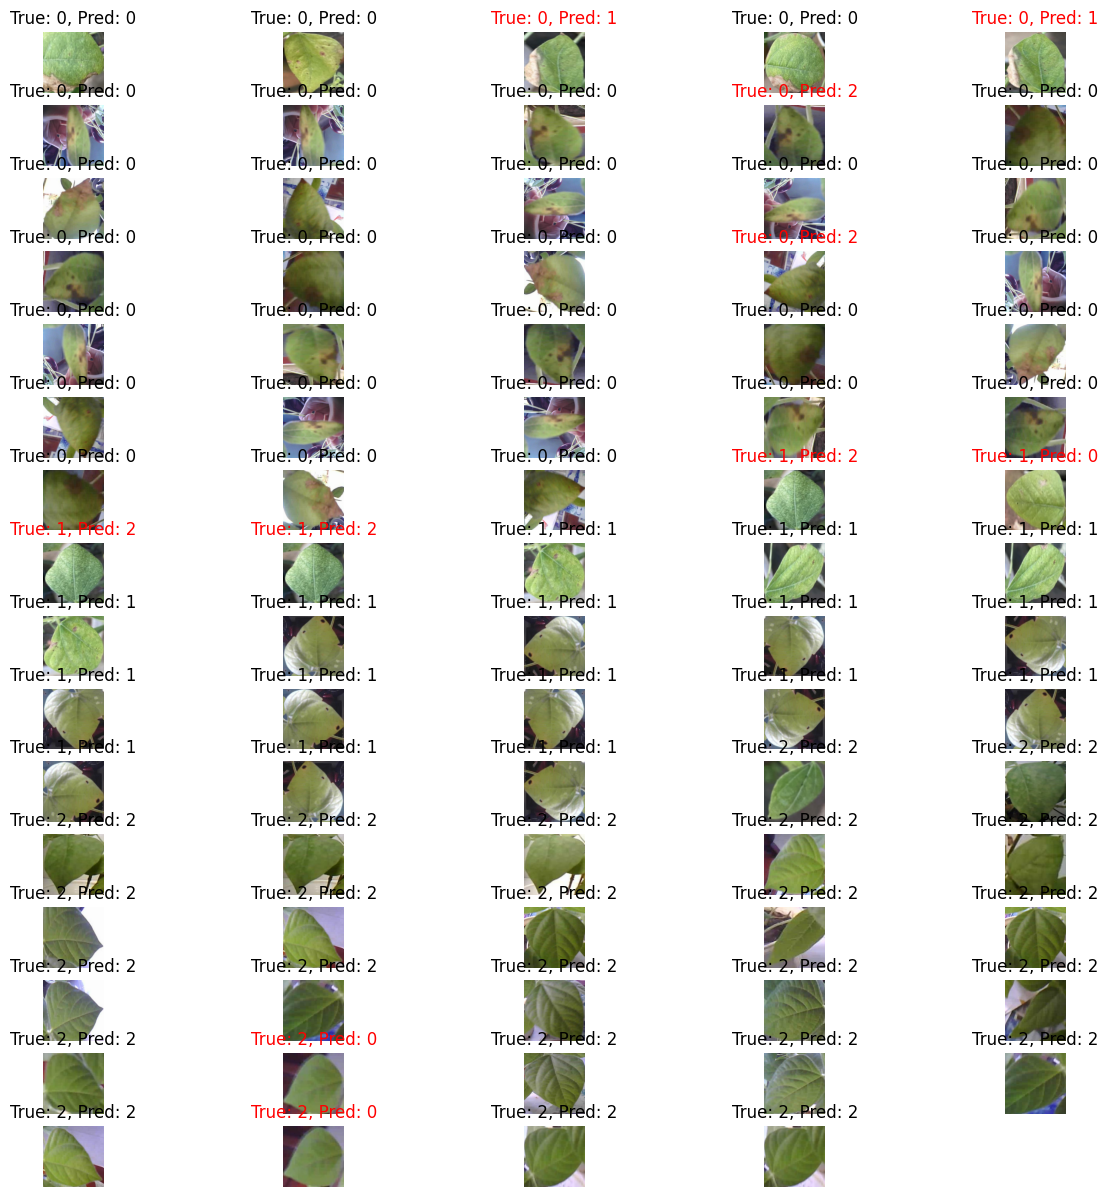

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


# Dự đoán nhãn cho bộ test
y_test_pred = np.argmax(final_model.predict(test_ds), axis=-1)

# Lấy nhãn thực từ bộ test
y_test_true = np.concatenate([y for x, y in test_ds], axis=0)
y_test_true = np.argmax(y_test_true, axis=-1)

# Lấy các hình ảnh từ bộ test
test_images = np.concatenate([x for x, y in test_ds], axis=0)

# Số lượng hình ảnh cần hiển thị (có thể thay đổi tùy theo nhu cầu)
num_images = 79

# Hiển thị các hình ảnh cùng với nhãn dự đoán và nhãn thực
plt.figure(figsize=(15, 15))
for i in range(num_images):
    plt.subplot(16, 5, i + 1)
    plt.imshow(test_images[i].astype("uint8"))
    if y_test_true[i] == y_test_pred[i]:
        plt.title(f"True: {y_test_true[i]}, Pred: {y_test_pred[i]}")
    else:
        plt.title(f"True: {y_test_true[i]}, Pred: {y_test_pred[i]}", color='red')
    plt.axis('off')
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test_true, y_test_pred)

print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.8780


In [ ]:
import os
os.makedirs("history", exist_ok=True)

hist_df = pd.DataFrame(history.history)
hist_df.to_csv("history/history_vgg19.csv", index=False)

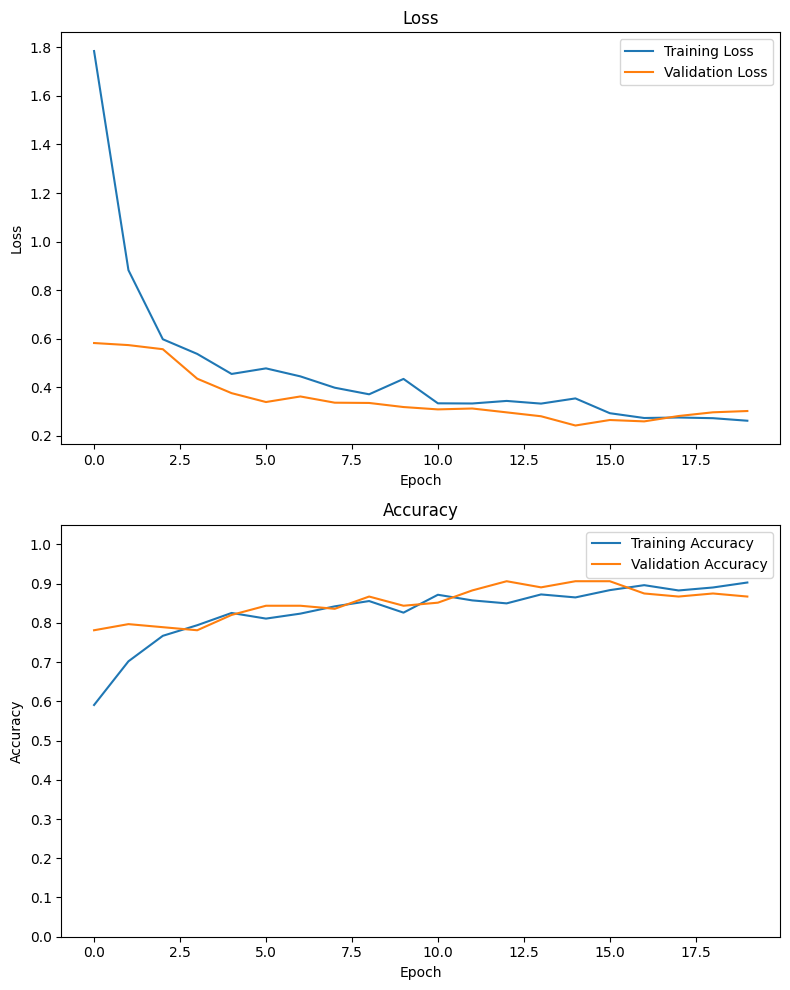

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

history_df = pd.read_csv("history/history_vgg19.csv")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

ax1.set_title('Loss')
ax1.plot(history_df['loss'], label='Training Loss')
ax1.plot(history_df['val_loss'], label='Validation Loss')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()

ax2.set_title('Accuracy')
ax2.plot(history_df['accuracy'], label='Training Accuracy')
ax2.plot(history_df['val_accuracy'], label='Validation Accuracy')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.set_ylim(0, 1.05)
ax2.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
ax2.legend()

plt.tight_layout()
plt.show()

In [ ]:
y_test_pred = np.argmax(final_model.predict(test_ds), axis=-1)

3/3 [==============================] - 0s 168ms/step


In [ ]:
def format_percent(val):
    return "{:.2f}%".format(val * 100)

In [ ]:
report = classification_report(y_test_true, y_test_pred, digits=4, output_dict=True)
class_report = pd.DataFrame(report).transpose()
class_report.iloc[:, :3] = class_report.iloc[:, :3].applymap(lambda x: x * 100)
class_report = class_report.style.format("{:.2f}", subset=pd.IndexSlice[:, ['precision', 'recall', 'f1-score']])\
                              .format("{:.0f}", subset=pd.IndexSlice[:, ['support']])
class_report

,precision,recall,f1-score,support
0,90.62,87.88,89.23,33
1,88.89,80.00,84.21,20
2,84.38,93.10,88.52,29
accuracy,87.80,87.80,87.80,1
macro avg,87.96,86.99,87.32,82
weighted avg,87.99,87.80,87.76,82


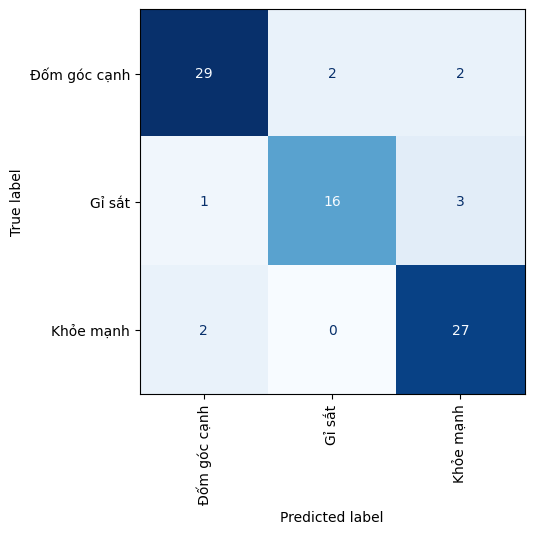

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Giả sử bạn đã có các tên lớp như sau:
class_names = ["Đốm góc cạnh", "Gỉ sắt", "Khỏe mạnh"]

# Lấy các nhãn thực tế và dự đoán từ mô hình
# y_test_true là các nhãn thực tế
# y_test_pred là các nhãn dự đoán từ mô hình

# Giả sử y_test_true và y_test_pred đã được định nghĩa trước đó
# Bạn có thể cần chuyển đổi chúng thành các định dạng phù hợp (ví dụ: từ one-hot encoding thành các nhãn số nguyên)

# Tính toán confusion matrix
conf = confusion_matrix(y_test_true, y_test_pred)

# Tạo biểu đồ confusion matrix
disp = ConfusionMatrixDisplay(conf, display_labels=class_names)
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax, xticks_rotation=90, cmap="Blues", colorbar=False)
plt.show()
